# Unsupervised Clustering Pipeline:  COVID-19 and Mental Health

We have gathered posts from a seleted set of subreddits, including several relevant to mental health.  Through supervised classification of posts to their subreddits of origin, we will identify the distinguishing characteristics of each subreddit and develop an approch to track changes over time in prediction certainty and results as the pandemic alters post content.  Through unsupervised clustering of these posts, we aim to:

1. Identify natural subgroupings among the posts (e.g., do posts from subreddits related to anxiety disorders cluster separately from posts on subreddits related to mood disorders, or psychotic disorders)
2. Track changes in representation of these natural subgroupings over the progression of the pandemic

To accomplish this, we use methods to determine the appropriate cluster number and to define clusters.  Then, we select a final cluster set and identify the features most characteristic of the clusters.  Finally, use these clusters to characterize mental health subreddits in the absence of a pandemic, to investigate changes in cluster representation on mental health subreddits during the pandemic, and to characterize non-mental-health related subreddits during the pandemic (e.g., r/COVID19_support)

In [ ]:
# Import necessary packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import umap
import os
from datetime import datetime, timedelta
import pickle
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram, linkage

In [ ]:
import scipy.sparse

In [ ]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import nltk
import seaborn as sns; sns.set()
# import datetime
nltk.download('wordnet')
stemmer = SnowballStemmer(language='english')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Set seed for reproducibility
np.random.seed(0) 

In [ ]:
# Mount GDrive and attach it to the colab for data I/O
from google.colab import drive
drive.mount('/content/drive')

# # Open Science Framework path
# input_dir = './data/input/'
# output_dir = './data/output/'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Be sure to run any cells in the final section ("Repository of Useful Function Definitions"), which defines useful functions for basic operations.  This section is relegated to the end of the notebook for organizational clarity.

### Reload Data Objects, As Needed

In [ ]:
# To save/restore intermediate objects. These are outputted throughout the script for you to recreate.
embedding = pd.read_csv('/content/drive/My Drive/ML4HC_Final_Project/data/processed_tfidf_umap50k.csv')
processed_data = pd.read_csv('/content/drive/My Drive/ML4HC_Final_Project/data/processed_posts_preTFIDF.csv')
posts_tfidf_bow = scipy.sparse.load_npz('/content/drive/My Drive/ML4HC_Final_Project/data/processed_tfidf_sparse_matrix.npz')

# Import Data

From all available pre-pandemic data, select only mental health subreddits.  



In [ ]:
# Select files to import
data_folder = '/content/drive/My Drive/ML4HC_Final_Project/data/input/feature_extraction/'
all_filenames = os.listdir(data_folder)

# List candidate files to manually select mental health subreddits
current_filenames = current_filenames = [i for i in all_filenames if ".csv" in i]
current_filenames = current_filenames = [i for i in current_filenames if "_pre_" in i]
# print(current_filenames) 

mh_subreddit_filenames = ['suicidewatch_pre_features.csv',
 'depression_pre_features.csv',
 'ptsd_pre_features.csv',
 'anxiety_pre_features.csv',
 'socialanxiety_pre_features.csv',
 'healthanxiety_pre_features.csv',
 'bipolarreddit_pre_features.csv',
 'mentalhealth_pre_features.csv',
 'bpd_pre_features.csv',
 'schizophrenia_pre_features.csv',
 'paranoia_pre_features.csv',
 'EDAnonymous_pre_features.csv',
 'alcoholism_pre_features.csv',
 'addiction_pre_features.csv',
 'adhd_pre_features.csv',
 'psychosis_pre_features.csv',
 'mentalillness_pre_features.csv',
 'autism_pre_features.csv']
current_filenames = mh_subreddit_filenames 

In [ ]:
# Import and join files
# Will print filenames to allow progress tracking
reddit_data = pd.read_csv(data_folder +current_filenames[0], index_col=False)
for i in np.arange(1, len(current_filenames)):
  print(current_filenames[i])
  new_data = pd.read_csv(data_folder +current_filenames[i], index_col=False)
  reddit_data = pd.concat([reddit_data, new_data], axis=0)

# Examine all columns
reddit_data.columns

depression_pre_features.csv
ptsd_pre_features.csv
anxiety_pre_features.csv
socialanxiety_pre_features.csv
healthanxiety_pre_features.csv
bipolarreddit_pre_features.csv
mentalhealth_pre_features.csv
bpd_pre_features.csv
schizophrenia_pre_features.csv
paranoia_pre_features.csv
EDAnonymous_pre_features.csv
alcoholism_pre_features.csv
addiction_pre_features.csv
adhd_pre_features.csv
psychosis_pre_features.csv
mentalillness_pre_features.csv
autism_pre_features.csv


Index(['subreddit', 'author', 'date', 'post', 'automated_readability_index',
       'coleman_liau_index', 'flesch_kincaid_grade_level',
       'flesch_reading_ease', 'gulpease_index', 'gunning_fog_index', 'lix',
       'smog_index', 'wiener_sachtextformel', 'n_chars', 'n_long_words',
       'n_monosyllable_words', 'n_polysyllable_words', 'n_sents',
       'n_syllables', 'n_unique_words', 'n_words', 'sent_neg', 'sent_neu',
       'sent_pos', 'sent_compound', 'covid19_total', 'economic_stress_total',
       'isolation_total', 'substance_use_total', 'guns_total',
       'domestic_stress_total', 'suicidality_total', 'punctuation',
       'liwc_1st_pers', 'liwc_2nd_pers', 'liwc_3rd_pers', 'liwc_achievement',
       'liwc_adverbs', 'liwc_affective_processes', 'liwc_anger',
       'liwc_anxiety', 'liwc_articles_article', 'liwc_assent',
       'liwc_auxiliary_verbs', 'liwc_biological', 'liwc_body',
       'liwc_causation', 'liwc_certainty', 'liwc_cognitive',
       'liwc_common_verbs', 'liwc_c

# Process Posts to Extract Text Features

In [ ]:
# Preprocessing matches feature development for LDA
# Adapted from: https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [ ]:
processed_data = reddit_data['post'].map(preprocess)

In [ ]:
# Remove posts with fewer than 20 terms after preprocessing (57950 posts removed)
processed_lengths = list(map(lambda x: len(x),processed_data['post']))
newly_short_posts = np.where(np.array(processed_lengths)<20)[0]
reddit_data.index = np.arange(0,len(reddit_data))
reddit_data.drop(list(newly_short_posts), inplace=True)

In [ ]:
# Drop short posts from processed data
processed_data.index = np.arange(0,len(processed_data))
processed_data.drop(list(newly_short_posts), inplace=True)
processed_data.shape

(298641, 1)

In [ ]:
# Collapse separate terms into single string for TF-IDF
collapsed_processed_posts = list(map(lambda x: paste(x, collapse=" "),processed_data))

In [ ]:
# Add processed data to data frame
reddit_data['processed_post'] = collapsed_processed_posts

In [ ]:
# Option: To Explore BOW without TF-IDF
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 3), max_df = 0.75, min_df = 0.001)
post_bow = vectorizer.fit_transform(reddit_data['processed_post'])
print(vectorizer.get_feature_names()[0:10])
print(len(vectorizer.get_feature_names()))

# KMeans Clustering

Adapted from: https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html




In [ ]:
# Import required packages
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.cluster import KMeans, MiniBatchKMeans

In [ ]:
# Develop TF-IDF features
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), max_df=0.75, min_df=0.001, use_idf=True)
posts_tfidf_bow = vectorizer.fit_transform(reddit_data['processed_post'])

In [ ]:
# Examine TF-IDF features
print(vectorizer.get_feature_names()[0:20])
print(len(vectorizer.get_feature_names()))

['abandon', 'abandon issu', 'abdomen', 'abdomin', 'abi', 'abil', 'abilifi', 'abl', 'abl afford', 'abl control', 'abl enjoy', 'abl feel', 'abl focus', 'abl friend', 'abl function', 'abl handl', 'abl help', 'abl hold', 'abl live', 'abl sleep']
10402


In [ ]:
# Test different cluster sizes
init_vals = np.random.choice(np.arange(100), size=10, replace=False)
silhouette_vals = []
sse_vals = []
for selected_k in np.array([19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]):
  print("Cluster")
  print(selected_k)
  for i in np.arange(3):
    print("Rep")
    print(i)
    km = MiniBatchKMeans(n_clusters=selected_k, init='k-means++', n_init=1, init_size=1000, 
                     batch_size=1000, random_state = init_vals[i])
    km.fit(posts_tfidf_bow)
    silhouette_vals.append(metrics.silhouette_score(posts_tfidf_bow, km.labels_, sample_size=1000))
    sse_vals.append(km.inertia_)

In [ ]:
# Set k values to test
n_clusters = np.repeat(np.array([19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]), 3)

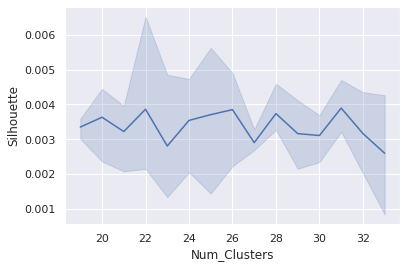

In [ ]:
# Plot silhouette scores
to_plot_d = {'Init_Value': np.repeat(init_vals[0:3], 15), 'Silhouette': silhouette_vals, 'Squared_Errors_Sum': sse_vals, 
             'Num_Clusters': n_clusters}
to_plot_df = pd.DataFrame(data=to_plot_d)
ax = sns.lineplot(x="Num_Clusters", y="Silhouette", data=to_plot_df)

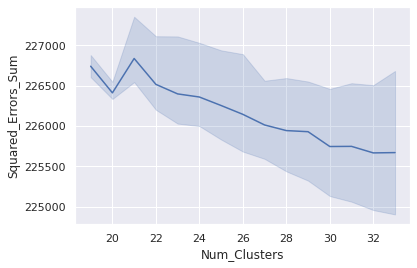

In [ ]:
# Plot Sum of Squared Errors values
ax = sns.lineplot(x="Num_Clusters", y="Squared_Errors_Sum", data=to_plot_df)

In [ ]:
# Generate clusters for a selected k
selected_k = 22
km = MiniBatchKMeans(n_clusters=selected_k, init='k-means++', n_init=3, init_size=1000, 
                     batch_size=1000)
km.fit(posts_tfidf_bow)

MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
                init_size=1000, max_iter=100, max_no_improvement=10,
                n_clusters=22, n_init=3, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [ ]:
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(posts_tfidf_bow, km.labels_, sample_size=1000))

Silhouette Coefficient: 0.003


In [ ]:
# Cluster "performance" for subreddit grouping
print("Homogeneity: %0.3f" % metrics.homogeneity_score(reddit_data['subreddit'], km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(reddit_data['subreddit'], km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(reddit_data['subreddit'], km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(reddit_data['subreddit'], km.labels_))

Homogeneity: 0.177
Completeness: 0.172
V-measure: 0.174
Adjusted Rand-Index: 0.055


In [ ]:
# Examine representation among the cells selected for the embedding
reddit_data.iloc[selected_cells,:]['subreddit'].value_counts()

In [ ]:
# Identify the top terms for each cluster, using the TF-IDF terms with the highest values in the centroid
# Adapted From: https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html

print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]

terms = vectorizer.get_feature_names()
for i in range(selected_k):
  print("Cluster %d:" % i, end='')
  for ind in order_centroids[i, :20]:
    print(' %s' % terms[ind], end='')
  print() 

Top terms per cluster:
Cluster 0: drive anxieti driver road licens feel like time know work go think accid want home start year get thing test
Cluster 1: adhd diagnos like medic thing think work test help time focus know diagnosi school diagnos adhd feel symptom peopl year start
Cluster 2: mother year parent famili brother life live abus time know go want father sister like school tell help feel think
Cluster 3: feel like feel like know want peopl think time life thing go friend talk make person year work help depress anymor
Cluster 4: fuck want life hate shit like feel know peopl go kill think live anymor time tire friend thing love care
Cluster 5: mental health mental health https help ill mental ill peopl disord issu know like feel want post survey need https reddit reddit anxieti
Cluster 6: med take work take med feel like medic help start time go adhd know year effect week think need want anxieti
Cluster 7: suicid want thought life kill suicid thought think feel know help attempt 

Cluster 0: "Bipolar/Borderline"

- disord bipolar diagnos depress diagnosi anxieti person disord bipolar disord person like know feel think mental year symptom peopl borderlin help anxieti disord

Cluster 1: "Advertisements?"

- hack servic contact issu contact devic credit card twitter spous hangout snapchat network expos credit hire instagram card facebook cheat rule special

Cluster 2: "Unknown_2"

- like think know feel time help go thing peopl look want need work start get year today say tri anxieti

Cluster 3: "ADHD"

- adhd diagnos like medic thing think help work focus time know diagnosi feel diagnos adhd test peopl symptom year med life

Cluster 4: "Unknown_2"

- feel like feel like know want think peopl time thing life go depress make talk help friend start person work year

Cluster 5: "Medication"

- medic med take effect doctor adderal dose work vyvans feel start prescrib help like experi anxieti week month time year

Cluster 6: "Sleeplessness"

- sleep night wake asleep hour fall asleep feel like fall time dream go anxieti think awak know work nightmar help want

Cluster 7: "Social Anxiety"

- social social anxieti anxieti peopl talk like feel think friend know want convers time person go thing awkward interact work start

Cluster 8: "Angry/Expletive"

- fuck want shit like life feel know peopl go think kill hate time fuck fuck live anymor friend thing tell year

Cluster 9: "EatingHabits_1"

- eat bing calori restrict eat disord like disord feel weight food purg fast know want go fuck think week today meal

Cluster 10: "SubstanceUse/Alcohol"

- drink alcohol sober night beer know feel time year like go want stop week start think help day quit problem

Cluster 11: "PolarizedEmotions_?"

- hate want feel like peopl life know hate hate fuck think love wish live friend time go thing feel like hate life kill

Cluster 12: "WeightChange"

- weight gain lose weight lose gain weight eat like pound bodi look feel weigh want restrict weight loss know bing weight gain loss calori

Cluster 13: "School"

- school work class year time like go feel know colleg start want think high high school grade life thing week need

Cluster 14: "Relationships"

- emot feel like know thing peopl think want time relationship abus life feel like person love help depress control go year

Cluster 15: "Resources"

- https mental mental health health help peopl ill mental ill youtub issu https youtub reddit https reddit post survey https youtub watch youtub watch like depress feel

Cluster 16: "EatingHabits_2"

- food purg eat bing like calori meal feel want know go restrict time think fast fuck today dinner hungri safe food

Cluster 17: "Friends/Support"

- friend talk like know feel want peopl best friend best tell think time go year say hang thing person life group

Cluster 18: "PanicAttacks"

- anxieti attack panic panic attack feel heart like go start think have pain symptom know time breath help chest doctor year

Cluster 19: "Philosophical_?"

- want know life think feel like time tell go thing year love peopl live help say suicid depress talk friend

Cluster 20: "Exhaustion"

- tire feel want life like know anymor time live tire tire think peopl go tri fuck depress tire feel work feel like better

Cluster 21: "WaterConsumption"

- water drink drink water like feel eat go know time fast today day food think bottl shower hour help work take

In [ ]:
# Define cluster annotations based on results above
cluster_annotations = ["Bipolar/Borderline", "Advertisements?","Unknown_1", "ADHD","Unknown_2", 
                       "Medication", "Sleeplessness", "Social Anxiety", "Angry/Expletive", "EatingHabits_1",
                       "SubstanceUse/Alcohol", "PolarizedEmotions_?", "WeightChange", "School", "Relationships", 
                       "Resources", "EatingHabits_2", "Friends/Support", "PanicAttacks", "Philosophical_?",
                       "Exhaustion", "WaterConsumption"]

In [ ]:
# Store cluster numbers and annotations 
reddit_data['cluster_number'] = km.labels_

reddit_data.index = np.arange(len(reddit_data))
reddit_data['cluster_annotations'] = np.ones(len(reddit_data))
for i in np.arange(22):
  selected_rows = np.where(reddit_data['cluster_number']==i)[0]
  reddit_data.loc[selected_rows,'cluster_annotations'] = np.repeat([cluster_annotations[i]], len(selected_rows))

reddit_data['cluster_annotations'].value_counts()

PolarizedEmotions_?     57396
EatingHabits_1          24698
School                  20683
Unknown_2               18151
Resources               16274
ADHD                    12646
SubstanceUse/Alcohol    11157
Angry/Expletive          9296
EatingHabits_2           8533
Friends/Support          8325
Exhaustion               8273
Social Anxiety           7730
Medication               7562
Advertisements?          7046
Philosophical_?          5543
Relationships            5344
WeightChange             5199
Sleeplessness            4221
PanicAttacks             1366
Bipolar/Borderline       1248
WaterConsumption            1
Name: cluster_annotations, dtype: int64

In [ ]:
# For manual examination of posts in a selected cluster
list(reddit_data.iloc[np.where(reddit_data['cluster_annotations']=="School")[0], :]['post'][0:10])

['I’ve been slowly turning to the dark side. Jokes aside, (considering I believe humor is amazing at hiding my feelings), I have been slowly wishing death upon myself. I’ve pretty much started being open to the idea and now I’m thinking it’s a good idea. I don’t even feel very depressed, just empty.\n\nStory:\nSo I fell in love with someone, lets just say, somewhat unavailable who was older than I. Shut down and broke my humungous amount of confidence. I still believe after evaluating that she’s an amazing person whome I don’t feel good enough for. I tried, but could not be friends and failed that friendship with her. Being in love with her was the first time in awhile I was happy and didn’t think about suicide. However, after things didn’t work out, I changed my life to something fantasitc and I really enjoy it. I’m going to college almost full time, I work a full time job, and I volunteer at a hospital. I plan on getting a DO/Phd so I can be a neurologust or family doctor. I’ve met a

In [ ]:
# Examine Subreddit Representation by Cluster
reddit_data.iloc[np.where(km.labels_==0)[0],:]['subreddit'].value_counts()

mentalhealth     1055
bpd              1037
bipolarreddit     891
schizophrenia     394
mentalillness     264
autism            220
anxiety           214
ptsd              200
depression        168
adhd              151
suicidewatch      114
EDAnonymous       102
psychosis          49
socialanxiety      47
addiction          38
healthanxiety      26
alcoholism          7
paranoia            2
Name: subreddit, dtype: int64

### Test statistical associations
The hypergeometric distribution models drawing objects from a bin. M is the total number of objects, n is total number of Type I objects. The random variate represents the number of Type I objects in N drawn without replacement from the total population.

In [ ]:
from scipy.stats import hypergeom

In [ ]:
### Hypergeometric Test for cluster representation in subreddits

n_tests = len(np.unique(reddit_data['subreddit']))*len(np.unique(reddit_data['cluster_annotations']))
bonf_thresh = 0.05/n_tests
print("Bonferroni threshold is ", bonf_thresh)
n_sig_enrichments = 0

for sub in np.unique(reddit_data['subreddit']):
  for clust in np.unique(reddit_data['cluster_annotations']):

    #M is the population size (previously N):  all posts on all subs
    M = len(reddit_data)

    # n is the number of successes in the population (previously K)
    n= len(np.where(reddit_data['cluster_annotations']==clust)[0])

    # N is the sample size (previously n):  all post in this subreddit
    N = len(np.where(reddit_data['subreddit']==sub)[0])

    # X is the number of drawn “successes”:  posts in this sub from the candidate cluster
    x = len(np.intersect1d(np.where(reddit_data['subreddit']==sub)[0], 
                       np.where(reddit_data['cluster_annotations']==clust)[0]))
    
    p_val = hypergeom.sf(x-1, M, n, N)
    #if p_val < 0.05:
    #  print("Nominal", sub, " ", clust)
    if p_val < bonf_thresh:
      print("MHT significant: ", sub, " ", clust)
      n_sig_enrichments += 1

print("Total Significant Enrichments: ", n_sig_enrichments)

Bonferroni threshold is  0.00013227513227513228
MHT significant:  EDAnonymous   Angry/Expletive
MHT significant:  EDAnonymous   Philosophical_?
MHT significant:  addiction   PanicAttacks
MHT significant:  addiction   PolarizedEmotions_?
MHT significant:  addiction   Relationships
MHT significant:  addiction   Unknown_2
MHT significant:  adhd   Advertisements?
MHT significant:  adhd   EatingHabits_2
MHT significant:  adhd   PanicAttacks
MHT significant:  adhd   PolarizedEmotions_?
MHT significant:  adhd   Sleeplessness
MHT significant:  alcoholism   Relationships
MHT significant:  anxiety   Bipolar/Borderline
MHT significant:  anxiety   EatingHabits_1
MHT significant:  anxiety   EatingHabits_2
MHT significant:  anxiety   Exhaustion
MHT significant:  anxiety   PolarizedEmotions_?
MHT significant:  anxiety   Resources
MHT significant:  autism   Medication
MHT significant:  autism   PanicAttacks
MHT significant:  autism   PolarizedEmotions_?
MHT significant:  autism   Resources
MHT signifi

In [ ]:
# Number of significant enrichments
n_sig_enrichments

77

[Text(0, 0, 'socialanxiety'),
 Text(0, 0, 'depression'),
 Text(0, 0, 'bpd'),
 Text(0, 0, 'mentalhealth'),
 Text(0, 0, 'suicidewatch'),
 Text(0, 0, 'anxiety'),
 Text(0, 0, 'EDAnonymous'),
 Text(0, 0, 'autism'),
 Text(0, 0, 'adhd'),
 Text(0, 0, 'ptsd'),
 Text(0, 0, 'schizophrenia'),
 Text(0, 0, 'addiction'),
 Text(0, 0, 'mentalillness'),
 Text(0, 0, 'bipolarreddit'),
 Text(0, 0, 'alcoholism'),
 Text(0, 0, 'psychosis'),
 Text(0, 0, 'healthanxiety'),
 Text(0, 0, 'paranoia')]

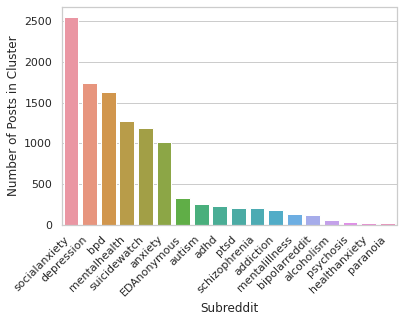

In [ ]:
# Show Representation of Topic Across Multiple Subreddits

# Select example subreddit 
cluster_label = "SubstanceUse/Alcohol"

# Plot representation
counts = reddit_data.iloc[np.where(reddit_data['cluster_annotations']==cluster_label)[0],:]['subreddit'].value_counts()
counts
to_plot_df = pd.DataFrame({"Number of Posts in Cluster": counts, "Subreddit": counts.index})
sns.set(style="whitegrid")
ax = sns.barplot(x="Subreddit", y="Number of Posts in Cluster", data=to_plot_df)
ax.set_xticklabels(
    ax.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    #fontsize='x-large'
)

In [ ]:
# Examine alcohol cluster on alcoholism subreddit
# Sixth most common, first most common is Relationships
sub = "alcoholism"
reddit_data.iloc[np.where(reddit_data['subreddit']==sub)[0],:]['cluster_annotations'].value_counts()/len(np.where(reddit_data['subreddit']==sub)[0])

Relationships           0.667224
PolarizedEmotions_?     0.178191
Unknown_2               0.043869
EatingHabits_1          0.028619
School                  0.021099
SubstanceUse/Alcohol    0.010863
Medication              0.008356
ADHD                    0.007311
Resources               0.007103
WeightChange            0.005222
Exhaustion              0.003969
Angry/Expletive         0.003133
EatingHabits_2          0.002716
Friends/Support         0.002716
Bipolar/Borderline      0.002507
Philosophical_?         0.002298
Social Anxiety          0.002089
PanicAttacks            0.001462
Sleeplessness           0.001253
Name: cluster_annotations, dtype: float64

In [ ]:
# Save intermediate object
reddit_data.to_csv('/content/drive/My Drive/ML4HC_Final_Project/data/assigned_unsup_clusters.csv', index=False) 

# Visualize with UMAP

In [ ]:
import umap

In [ ]:
n_subset =50000
selected_cells = np.random.choice(np.arange(posts_tfidf_bow.shape[0]), size = n_subset, replace = False)
mapper = umap.UMAP(metric='hellinger', random_state=42).fit(posts_tfidf_bow[selected_cells,:])

In [ ]:
embedding = mapper.transform(posts_tfidf_bow[selected_cells,:]) 

In [ ]:
# To save/restore intermediate objects 
df_embedding = pd.DataFrame(embedding)
df_embedding.to_csv('/content/drive/My Drive/ML4HC_Final_Project/data/processed_tfidf_umap50k.csv', index=False) 

In [ ]:
# To save/restore intermediate objects 
df_selected_cells = pd.DataFrame(selected_cells)
df_selected_cells.to_csv('/content/drive/My Drive/ML4HC_Final_Project/data/selected_cells.csv', index=False) 

In [ ]:
# To save/restore intermediate objects 
# Note:  Saved Before Removal of Short Posts
df_processed_posts = pd.DataFrame(processed_data)
df_processed_posts.to_csv('/content/drive/My Drive/ML4HC_Final_Project/data/processed_posts_preTFIDF.csv', index=False) 

In [ ]:
# To save/restore intermediate objects 
reddit_data = pd.read_csv('/content/drive/My Drive/ML4HC_Final_Project/data/assigned_unsup_clusters.csv')

In [ ]:
# To save/restore intermediate objects
scipy.sparse.save_npz('/content/drive/My Drive/ML4HC_Final_Project/data/processed_tfidf_sparse_matrix.npz', posts_tfidf_bow)

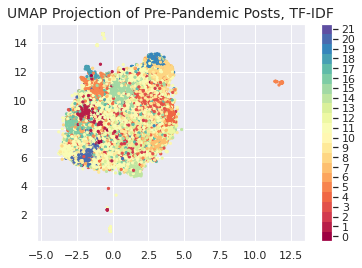

In [ ]:
# Plot Clusters on UMAP
plt.scatter(embedding[:, 0], embedding[:, 1], c=reddit_data.iloc[selected_cells,:]['cluster_number'], cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
num_clust = len(np.unique(reddit_data['cluster_number']))
plt.colorbar(boundaries=np.arange(num_clust+1)-0.5).set_ticks(np.arange(num_clust))
plt.title('UMAP Projection of Pre-Pandemic Posts, TF-IDF', fontsize=14);

# Examine Cluster Representation in Pandemic Data

In [ ]:
# Select files to import
data_folder = '/content/drive/My Drive/ML4HC_Final_Project/data/input/feature_extraction/'
all_filenames = os.listdir(data_folder)

# List candidate files to manually select mental health subreddits
current_filenames = current_filenames = [i for i in all_filenames if ".csv" in i]
current_filenames = current_filenames = [i for i in current_filenames if "_post_" in i]
print(current_filenames) 

['ForeverAlone_post_features.csv', 'UKPersonalFinance_post_features.csv', 'mentalillness_post_features.csv', 'addiction_post_features.csv', 'socialanxiety_post_features.csv', 'ptsd_post_features.csv', 'bipolarreddit_post_features.csv', 'healthanxiety_post_features.csv', 'MakeNewFriendsHere_post_features.csv', 'economy_post_features.csv', 'CanadaPolitics_post_features.csv', 'divorce_post_features.csv', 'unitedkingdom_post_features.csv', 'guns_post_features.csv', 'India_post_features.csv', 'Canada_post_features.csv', 'paranoia_post_features.csv', 'COVID19_support_post_features.csv', 'psychosis_post_features.csv', 'jokes_post_features.csv', 'fitness_post_features.csv', 'bpd_post_features.csv', 'meditation_post_features.csv', 'mentalhealth_post_features.csv', 'EDAnonymous_post_features.csv', 'depression_post_features.csv', 'relationships_post_features.csv', 'schizophrenia_post_features.csv', 'mindfulness_post_features.csv', 'personalfinance_post_features.csv', 'anxiety_post_features.csv', 

In [ ]:
# To import non-mental health posts with relevance to the pandemic
current_filenames = ['COVID19_support_post_features.csv', 'relationships_post_features.csv', 
                     'personalfinance_post_features.csv', 'legaladvice_post_features.csv']

In [ ]:
# Import and join files
# Will print filenames to allow progress tracking
pandemic_data = pd.read_csv(data_folder +current_filenames[0], index_col=False)
for i in np.arange(1, len(current_filenames)):
  print(current_filenames[i])
  new_data = pd.read_csv(data_folder +current_filenames[i], index_col=False)
  pandemic_data = pd.concat([pandemic_data, new_data], axis=0)

# Examine all columns
pandemic_data.columns

relationships_post_features.csv
personalfinance_post_features.csv
legaladvice_post_features.csv


Index(['subreddit', 'author', 'date', 'post', 'automated_readability_index',
       'coleman_liau_index', 'flesch_kincaid_grade_level',
       'flesch_reading_ease', 'gulpease_index', 'gunning_fog_index', 'lix',
       'smog_index', 'wiener_sachtextformel', 'n_chars', 'n_long_words',
       'n_monosyllable_words', 'n_polysyllable_words', 'n_sents',
       'n_syllables', 'n_unique_words', 'n_words', 'sent_neg', 'sent_neu',
       'sent_pos', 'sent_compound', 'covid19_total', 'economic_stress_total',
       'isolation_total', 'substance_use_total', 'guns_total',
       'domestic_stress_total', 'suicidality_total', 'punctuation',
       'liwc_1st_pers', 'liwc_2nd_pers', 'liwc_3rd_pers', 'liwc_achievement',
       'liwc_adverbs', 'liwc_affective_processes', 'liwc_anger',
       'liwc_anxiety', 'liwc_articles_article', 'liwc_assent',
       'liwc_auxiliary_verbs', 'liwc_biological', 'liwc_body',
       'liwc_causation', 'liwc_certainty', 'liwc_cognitive',
       'liwc_common_verbs', 'liwc_c

In [ ]:
# Preprocess posts before TF-IDF
processed_data = pandemic_data['post'].map(preprocess)

# Remove posts with fewer than 20 terms after preprocessing 
processed_lengths = list(map(lambda x: len(x),processed_data))
newly_short_posts = np.where(np.array(processed_lengths)<20)[0]
pandemic_data.index = np.arange(0,len(pandemic_data))
pandemic_data.drop(list(newly_short_posts), inplace=True)

processed_data.index = np.arange(0,len(processed_data))
processed_data.drop(list(newly_short_posts), inplace=True)
processed_data.shape

collapsed_processed_posts = list(map(lambda x: paste(x, collapse=" "),processed_data))
pandemic_data['processed_post'] = collapsed_processed_posts

In [ ]:
# Examine number of posts
pandemic_data.shape

(163502, 96)

In [ ]:
# Number of posts removed due to length = 12281
len(newly_short_posts)

12281

In [ ]:
# Save intermediate object
pandemic_data.to_csv('/content/drive/My Drive/ML4HC_Final_Project/data/pandemic_data.csv', index=False) 

In [ ]:
# Save intermediate object
pandemic_data = pd.read_csv('/content/drive/My Drive/ML4HC_Final_Project/data/pandemic_data.csv')

In [ ]:
# Develop TF-IDF features
vectorizer_pandemic = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), max_df=0.75, min_df=0.001, use_idf=True)
pandemic_tfidf_bow = vectorizer_pandemic.fit_transform(pandemic_data['processed_post'])
print(vectorizer_pandemic.get_feature_names()[0:20])
print(len(vectorizer_pandemic.get_feature_names()))

['aback', 'abandon', 'abid', 'abil', 'abl', 'abl afford', 'abl claim', 'abl come', 'abl file', 'abl handl', 'abl help', 'abl leav', 'abl live', 'abl money', 'abl month', 'abl provid', 'abl rent', 'abl save', 'abl stay', 'abl talk']
11729


In [ ]:
# Save intermediate object
scipy.sparse.save_npz('/content/drive/My Drive/ML4HC_Final_Project/data/pandemic_tfidf_bow.npz', pandemic_tfidf_bow)

In [ ]:
# Convert dates to date format
pandemic_data['date'] = [datetime.strptime(x, '%Y/%m/%d') for x in pandemic_data['date']]

# Make date groups by week
min_date = np.min(panemic_data['date'])
max_date = np.max(pandemic_data['date'])
pandemic_data['week'] = np.ones(pandemic_data.shape[0])
start_week = min_date + timedelta(days=7)
n_week = 2
week_col = np.where(pandemic_data.columns=='week')[0]
while start_week <= max_date:
  end_week = start_week + timedelta(days=6)
  loc_posts_after_start = np.where(pandemic_data['date'] >=start_week)[0]
  loc_posts_before_end = np.where(pandemic_data['date'] <=end_week)[0]
  loc_week_dates = np.intersect1d(loc_posts_after_start, loc_posts_before_end)
  pandemic_data.iloc[loc_week_dates, week_col] = np.ones(len(loc_week_dates))*n_week
  n_week = n_week + 1
  start_week = start_week + timedelta(days=7)

In [ ]:
# Save intermediate object
pd.DataFrame(vectorizer_pandemic.get_feature_names()).to_csv('/content/drive/My Drive/ML4HC_Final_Project/data/pandemic_tfidf_features.csv', index=False)

In [ ]:
# Restore intermediate object
pandemic_tfidf_features = pd.read_csv('/content/drive/My Drive/ML4HC_Final_Project/data/pandemic_tfidf_features.csv')
pandemic_tfidf_features = list(pandemic_tfidf_features.iloc[:,0])

### Determine Representation of Conversation Themes on Covid Support

In [ ]:
# Identify relevant posts
covid_support_posts = np.where(pandemic_data['subreddit']=="COVID19_support")[0]
relationship_posts = np.where(pandemic_data['subreddit']=="relationships")[0]

In [ ]:
from scipy.spatial import distance

In [ ]:
# Develop TF-IDF features
pandemic_tfidf_transform = vectorizer.transform(pandemic_data['processed_post'])

In [ ]:
# COVID-19 Support topic representation
assigned_cluster = []
for n_post in np.arange(len(covid_support_posts)):
  distances = np.zeros(22)
  for n_centroid in np.arange(22):
    distances[n_centroid] = distance.euclidean(km.cluster_centers_[n_centroid],pandemic_tfidf_transform[covid_support_posts,:][n_post,:].toarray())
  assigned_cluster.append(cluster_annotations[np.argmin(distances)])

pd.DataFrame(assigned_cluster).iloc[:,0].value_counts()


SubstanceUse/Alcohol    732
WaterConsumption        271
Friends/Support         185
ADHD                    167
Bipolar/Borderline      117
Unknown_2                94
Resources                42
Philosophical_?          39
School                   34
WeightChange             27
Medication               20
Relationships            20
Angry/Expletive          19
PolarizedEmotions_?       9
Sleeplessness             9
Social Anxiety            6
EatingHabits_2            5
Advertisements?           3
Name: 0, dtype: int64

In [ ]:
# Conversation topic representation on Relationships subreddit 
assigned_cluster = []
for n_post in np.arange(len(relationship_posts)):
  distances = np.zeros(22)
  for n_centroid in np.arange(22):
    distances[n_centroid] = distance.euclidean(km.cluster_centers_[n_centroid],pandemic_tfidf_transform[relationship_posts,:][n_post,:].toarray())
  assigned_cluster.append(cluster_annotations[np.argmin(distances)])

pd.DataFrame(assigned_cluster).iloc[:,0].value_counts()


[Text(0, 0, 'SubstanceUse/Alcohol'),
 Text(0, 0, 'WaterConsumption'),
 Text(0, 0, 'Friends/Support'),
 Text(0, 0, 'ADHD'),
 Text(0, 0, 'Bipolar/Borderline'),
 Text(0, 0, 'Unknown_2'),
 Text(0, 0, 'Resources'),
 Text(0, 0, 'Philosophical_?'),
 Text(0, 0, 'School'),
 Text(0, 0, 'WeightChange'),
 Text(0, 0, 'Medication'),
 Text(0, 0, 'Relationships'),
 Text(0, 0, 'Angry/Expletive'),
 Text(0, 0, 'PolarizedEmotions_?'),
 Text(0, 0, 'Sleeplessness'),
 Text(0, 0, 'Social Anxiety'),
 Text(0, 0, 'EatingHabits_2'),
 Text(0, 0, 'Advertisements?')]

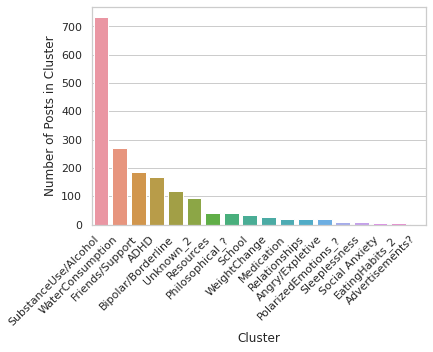

In [ ]:
# Show Representation of Topics Within the Subreddit
# (specific to the subreddit used to create assigned_cluster vector)
counts = pd.DataFrame(assigned_cluster).iloc[:,0].value_counts()
to_plot_df = pd.DataFrame({"Number of Posts in Cluster": counts, "Cluster": counts.index})
sns.set(style="whitegrid")
ax = sns.barplot(x="Cluster", y="Number of Posts in Cluster", data=to_plot_df)
ax.set_xticklabels(
    ax.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    #fontsize='x-large'
)



# Repository of Useful Function Definitions

In [ ]:
# Paste Function Equivalent
# Source: https://stackoverflow.com/questions/21292552/equivalent-of-paste-r-to-python

import functools
def reduce_concat(x, sep=""):
    return functools.reduce(lambda x, y: str(x) + sep + str(y), x)

def paste(*lists, sep=" ", collapse=None):
    result = map(lambda x: reduce_concat(x, sep=sep), zip(*lists))
    if collapse is not None:
        return reduce_concat(result, sep=collapse)
    return list(result)

# Example Use
#print(paste([1,2,3], [11,12,13], sep=','))
#print(paste([1,2,3], [11,12,13], sep=',', collapse=";"))